In [22]:
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
from scipy.integrate import quad
from scipy import special
from classes import P_dist_handler, H_pot
plt.rc('animation', html='jshtml')

In [23]:
def p_fun(x,T,k,x_0):
    t1 = np.sqrt(k/(2.0*np.pi*T))
    t2 = np.exp(-1.0/2.0*k*(x-x_0)**2/T)
    return t1*t2

ks = [1.0, 1.0, 10.0]
x0s = [0.0,1.0, 0.0]
T = 0.5#*273.15
Hs = []
for k, x0 in zip(ks, x0s):
    p_handler = P_dist_handler(x_min=x0-6, x_max=x0+6, p_func=p_fun)
    h = H_pot(T=T, k=k, x_0=x0, p_handler=p_handler)
    Hs.append(h)

## a) 
Plot the potential of the harmonic oscillator with some different values for the force constant, $k$. Plot the probability distribution. Evaulate the thermally averaged potential energy by direct integration in a finite range from some $x_{min}$ to some $x_{max}$. Neglect for now that this leads to a small error.

0.24999999999999964
0.24999999999999964
0.25000000000000006


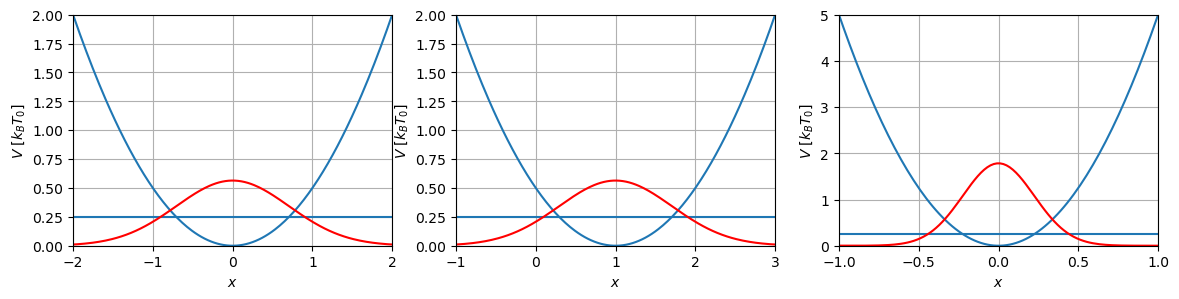

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(14,3))
x_lims = [[-2,2],[-1,3],[-1,1]]
y_lims = [[0,2], [0,2], [0,5]]
xs = np.linspace(-2.0, 2.0, 1000)
#Y = lambda x, T, k, x_0, x_min, x_max: np.sqrt(k/(2.0*np.pi))*np.exp(-k/2.0*(x-x_0)**2)/special.erf(x_max*np.sqrt(k/2.0)) #+ 1.0/(x_max-x_min)
for ax, x_lim, y_lim, pot, k, x0 in zip(axs, x_lims, y_lims, Hs, ks, x0s):
    ax.grid()
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$V$ $[k_BT_{0}]$")
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    pot.get_v_avg
    pot.plot(ax)
    print(pot.v_avg)

#I think the probababilty distributions are wrong, but i cannot recreat bjørks distributions even if i renormalize?

In [25]:
for pot in Hs:
    pot.clear_p_handler()

def p_fun(x,T,k,x_0):
    t1 = np.sqrt(k/(2.0*np.pi*T))
    t2 = np.exp(-1.0/2.0*k*(x-x_0)**2/T)
    return t1*t2

def Y(x, T, k, x_0):
    return np.exp(-1.0/2.0*k*(x-x_0)**2/T)
#Y = lambda x, T, k, x_0: np.sqrt(k/(2.0*np.pi))*np.exp(-k/2.0*(x-x_0)**2) + 1.0/(8.0)
x0s = [0.0,1.0,0.0]
x_pairs = [[-2.0, 2.0], [-2.0, 2.0], [-1.0, 1.0]]
for pot, x0, x_pair in zip(Hs, x0s, x_pairs):
    p_handler = P_dist_handler(x_min=x0+x_pair[0], x_max=x0+x_pair[1], Y=Y, N=20000)
    pot.p_handler = p_handler

0.24166054959272207
0.2419314623444841
0.2542320836989198


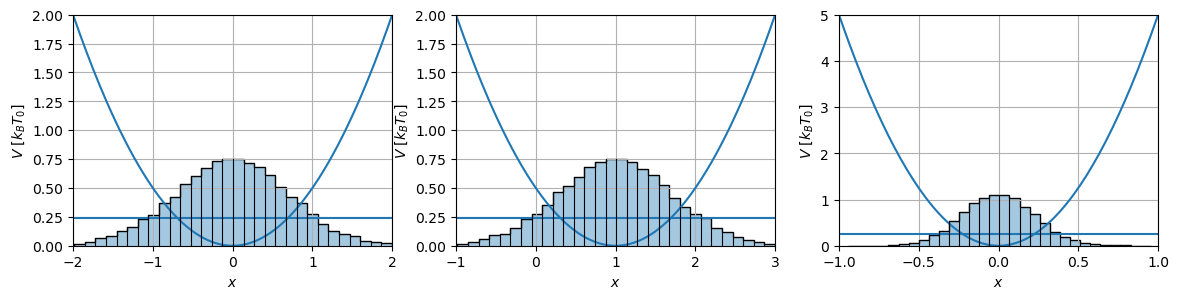

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(14,3))
x_lims = [[-2,2],[-1,3],[-1,1]]
y_lims = [[0,2], [0,2], [0,5]]

for ax, x_lim, y_lim, pot, k, x0 in zip(axs, x_lims, y_lims, Hs, ks, x0s):
    ax.grid()
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$V$ $[k_BT_0]$")
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    pot.get_v_avg
    print(pot.v_avg)
    pot.plot(ax)

In [27]:
for pot in Hs:
    pot.clear_p_handler()

Ts = np.linspace(0.01, 2, 2000)
cvs_energy = []
cvs_fluct = []
for T in Ts:
    Hs[0].T = T
    #print(Hs[0].T)
    p_handler = P_dist_handler(x_min=0.0-4.0, x_max=0.0+4.0, p_func=p_fun)
    Hs[0].p_handler = p_handler
    cv = Hs[0].get_cv("finite_difference")
    cvs_energy.append(cv)
    #print(cv)
    Hs[0].cv = None
    Hs[0].v_avg = None
    Hs[0].v_avg_squared = None
    cv = Hs[0].get_cv("analytical")
    cvs_fluct.append(cv)
    Hs[0].cv = None
    Hs[0].v_avg = None
    Hs[0].v_avg_squared = None

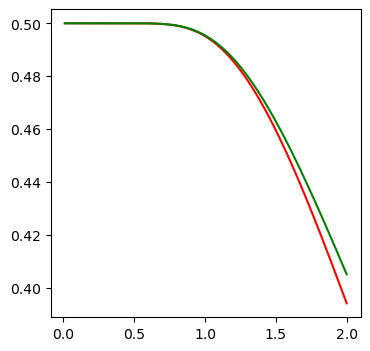

In [28]:
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(Ts, np.array(cvs_energy), c="red")
ax.plot(Ts, np.array(cvs_fluct), c="green")
#ax.set_xlim([200,300])